## Import Libraries

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import random
import shutil
import glob

## prepare data 

In [25]:
# make folder for train and validation and test set
train_dir='train'
val_dir='val'
test_dir='test'
os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)
os.makedirs(test_dir,exist_ok=True)

os.makedirs(os.path.join(train_dir,'covid'),exist_ok=True)
os.makedirs(os.path.join(train_dir,'normal'),exist_ok=True)

os.makedirs(os.path.join(val_dir,'covid'),exist_ok=True)
os.makedirs(os.path.join(val_dir,'normal'),exist_ok=True)

os.makedirs(os.path.join(test_dir,'covid'),exist_ok=True)
os.makedirs(os.path.join(test_dir,'normal'),exist_ok=True)

In [21]:
# split data and move it in folders of train , val and test
num_covid = len(os.listdir('COVID')) # number of covid data 
covid = os.listdir('COVID') # list covid data 
random.shuffle(covid) # shuffle covid data for spliting to train , validation and test data

num_normal=len(os.listdir('NORMAL')) #numver of normal data 
normal = os.listdir('NORMAL') # list normal data 
random.shuffle(covid) # shuffle normal data for spliting to train , validation and test data

print(f'Number of total data in category of covid : {num_covid}')
print(f'Number of total data in category of normal : {num_normal}')


Number of total data in category of covid : 196
Number of total data in category of normal : 196


In [26]:
# split and move 75% from data to train 
for i in range(int(num_covid * .75)):
    shutil.move(os.path.join('COVID',covid[i]),os.path.join(train_dir,'covid'))
    shutil.move(os.path.join('NORMAL',normal[i]),os.path.join(train_dir,'normal'))

In [27]:
# split and move 15% from data to validation 
for i in range(int(num_covid * .75),int(num_covid * .90)):
    shutil.move(os.path.join('COVID',covid[i]),os.path.join(val_dir,'covid'))
    shutil.move(os.path.join('NORMAL',normal[i]),os.path.join(val_dir,'normal'))

In [28]:
# split and move 10% from data to test 
for i in range(int(num_covid * .90), num_covid ):
    shutil.move(os.path.join('COVID',covid[i]),os.path.join(test_dir,'covid'))
    shutil.move(os.path.join('NORMAL',normal[i]),os.path.join(test_dir,'normal'))

## Data visualization

In [29]:
# print number of data for each directory for normal and covid
print("-------------------------------------------------\nnumber of image for training data set\n------------------------------------------------- ")
print(f"NORMAL  :  {len(os.listdir(os.path.join(train_dir,'normal')))} images")
print(f"COVID  :  {len(os.listdir(os.path.join(train_dir,'covid')))} images")

print("-------------------------------------------------\nnumber of image for validation data set \n-------------------------------------------------")
print(f"NORMAL  :  {len(os.listdir(os.path.join(val_dir,'normal')))} images")
print(f"COVID  :  {len(os.listdir(os.path.join(val_dir,'covid')))} images")

print("-------------------------------------------------\nnumber of image for test data set \n-------------------------------------------------")
print(f"NORMAL  :  {len(os.listdir(os.path.join(test_dir,'normal')))} images")
print(f"COVID  :  {len(os.listdir(os.path.join(test_dir,'covid')))} images")

-------------------------------------------------
number of image for training data set
------------------------------------------------- 
NORMAL  :  147 images
COVID  :  147 images
-------------------------------------------------
number of image for validation data set 
-------------------------------------------------
NORMAL  :  29 images
COVID  :  29 images
-------------------------------------------------
number of image for test data set 
-------------------------------------------------
NORMAL  :  20 images
COVID  :  20 images


### visualize sample covid images 

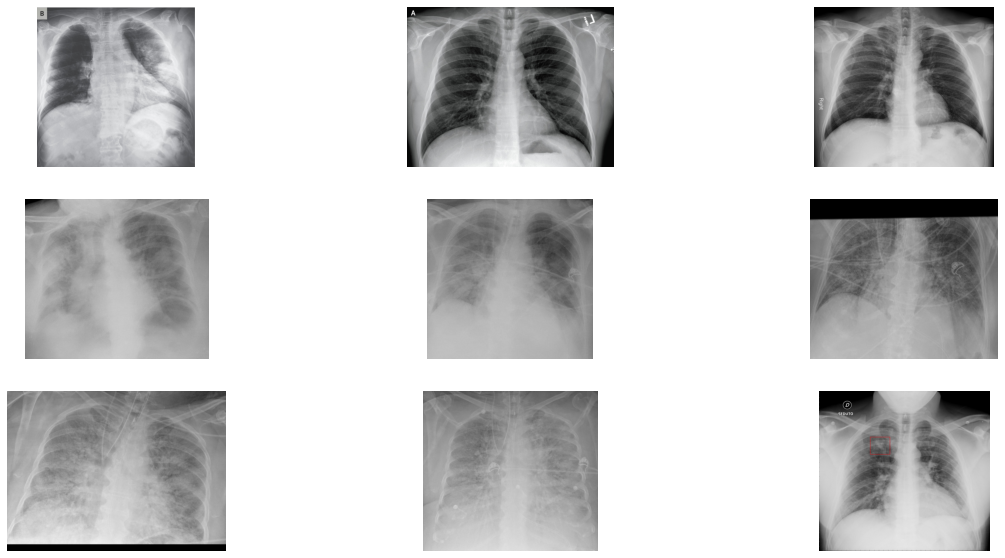

In [31]:
covid_dir='train/covid'
covid_img=os.listdir(covid_dir)
plt.figure(figsize=(20,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    img=plt.imread(os.path.join(covid_dir,covid_img[i]))
    plt.imshow(img,cmap='gray')
    plt.axis('off')

### visualize sample normal images

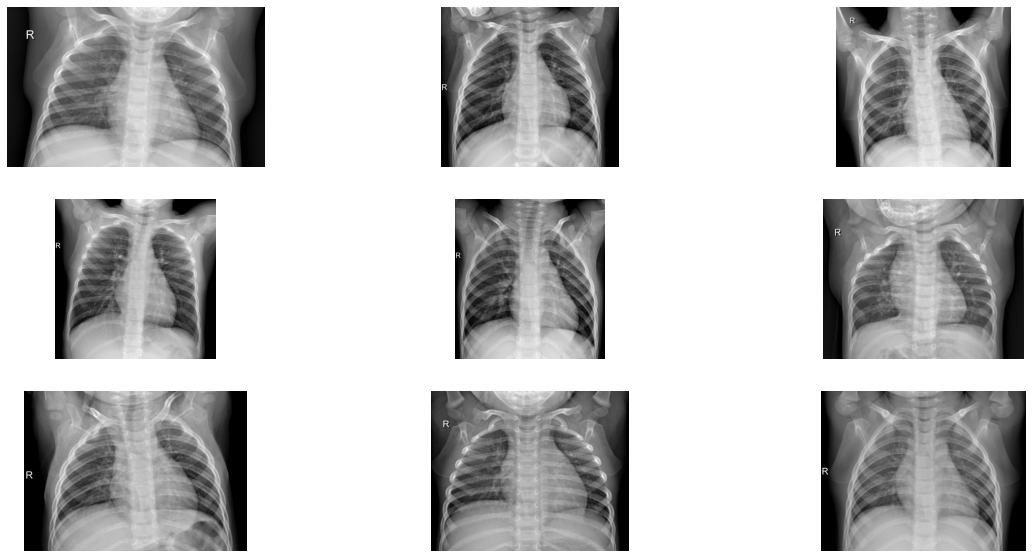

In [32]:
normal_dir='train/normal'
covid_img=os.listdir(normal_dir)
plt.figure(figsize=(20,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    img=plt.imread(os.path.join(normal_dir,covid_img[i]))
    plt.imshow(img,cmap='gray')
    plt.axis('off')

## Image Preprocessing 

Before training, we'll first modify our images to be better suited for training a convolutional neural network. For this task we'll use the Keras ImageDataGenerator function to perform data preprocessing and data augmentation

In [33]:

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

img_shape=(256,256)
# train generator for traing data
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=img_shape)
# validation generator for validation data
validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size= img_shape)
#test generator for test data
test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=img_shape)

Found 294 images belonging to 2 classes.
Found 58 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


## Custom CNN Model

### Setting Callback

In [36]:
#stop training when stop learn for 5 epoch
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

#Reduce learning rate by .2*lr when a metric has stopped improving for 2 epoch.
reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=.2)

In [37]:
def build_model(input_shape):
    
    inputs=keras.layers.Input(input_shape)
    # Block 1
    x=keras.layers.Conv2D(filters=16,kernel_size=(3,3),padding='valid')(inputs)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Activation('relu')(x)
    x=keras.layers.MaxPool2D()(x)
    x=keras.layers.Dropout(.2)(x)
    
    #Block 2
    x=keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='valid')(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Activation('relu')(x)
    x=keras.layers.MaxPool2D()(x)
    x=keras.layers.Dropout(.2)(x)
    
    #Block 3
    x=keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='valid')(x)
    x=keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='valid')(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.Activation('relu')(x)
    x=keras.layers.MaxPool2D()(x)
    x=keras.layers.Dropout(.4)(x)
    
    # Head
    x=keras.layers.Flatten()(x)
    x=keras.layers.Dense(64,activation='relu')(x)
    x=keras.layers.Dropout(.5)(x)
    # final layer
    output=keras.layers.Dense(1,activation='sigmoid')(x)
    
    model=keras.Model(inputs,output)
    
    return model

In [38]:
model=build_model((256,256,3))
model.compile(loss='binary_crossentropy',optimizer=tf.optimizers.Adam(lr=3e-5) ,metrics='binary_accuracy')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 254, 254, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0     

C:\Users\sayed\anaconda3\envs\py37gpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
 history=model.fit(train,epochs=20,validation_data=validation,callbacks=[early_stopping,reduce_lr])

Epoch 1/20
37/37 [==============================] - 30s 474ms/step - loss: 0.9264 - binary_accuracy: 0.5884 - val_loss: 0.6310 - val_binary_accuracy: 0.9655 - lr: 3.0000e-05
Epoch 2/20
37/37 [==============================] - 21s 538ms/step - loss: 0.4649 - binary_accuracy: 0.7891 - val_loss: 0.5972 - val_binary_accuracy: 0.5000 - lr: 3.0000e-05
Epoch 3/20
37/37 [==============================] - 15s 399ms/step - loss: 0.3479 - binary_accuracy: 0.8469 - val_loss: 0.5124 - val_binary_accuracy: 0.8103 - lr: 3.0000e-05
Epoch 4/20
37/37 [==============================] - 14s 370ms/step - loss: 0.3041 - binary_accuracy: 0.8946 - val_loss: 0.4334 - val_binary_accuracy: 0.8448 - lr: 3.0000e-05
Epoch 5/20
37/37 [==============================] - 14s 384ms/step - loss: 0.2426 - binary_accuracy: 0.8946 - val_loss: 0.3729 - val_binary_accuracy: 0.9138 - lr: 3.0000e-05
Epoch 6/20
37/37 [==============================] - 14s 385ms/step - loss: 0.2395 - binary_accuracy: 0.9252 - val_loss: 0.2373 - v

In [40]:
model.save('covid_model.h5')

In [41]:
score = model.evaluate(test, verbose = 1)
print('test loss:', score[0])
print('test accuracy:', score[1])

40/40 [==============================] - 2s 44ms/step - loss: 0.1177 - binary_accuracy: 0.9500
test loss: 0.1176614761352539
test accuracy: 0.949999988079071


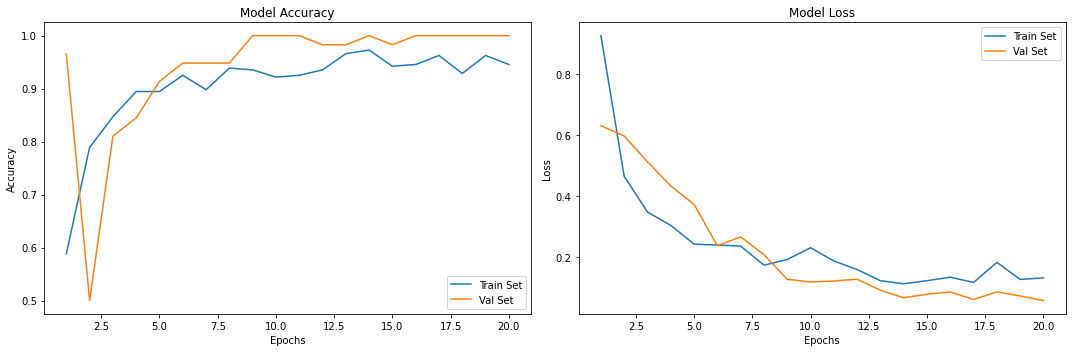

In [42]:
# plot model performance
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()